# Identify Fraud From Enron Email  

## 1. Project Overview  

Enron Corporation was once one of the world’s major energy and trading companies with 20,000 staff before its bankruptcy in 2002. Accounting fraud perpetrated by top executives resulted in one of the largest bankruptcies in U.S. History.  

This project is to apply machine learning algorithms to identify Enron Employees who may have committed fraud based on the public Enron financial and email dataset.  

## 2. Data Analysis  

In [6]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [7]:
import sys
import pickle
import math
import pprint
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
sns.set(style="white", color_codes=True)

sys.path.append("../tools/")
from feature_format import featureFormat

data_dict = pickle.load(open("./final_project_dataset.pkl", "r"))

### 2.1 Dataset Overview

In [17]:
print("Total data point: {}".format(len(data_dict)))

Total data point: 146


In [4]:
print("Total feature number: {}".format(len(data_dict["LAY KENNETH L"])))

Total feature number: 21


In [5]:
num = 0
for key, record in data_dict.iteritems():
    if record["poi"]:
        num += 1
print("Total number of POI in the dataset: {}".format(num))

Total number of POI in the dataset: 18


In [6]:
print("Complete feature list:")
feature_list = []
for key in data_dict["LAY KENNETH L"].keys():
    feature_list.append(key)
    print(key + "; "), 

Complete feature list:
salary;  to_messages;  deferral_payments;  total_payments;  exercised_stock_options;  bonus;  restricted_stock;  shared_receipt_with_poi;  restricted_stock_deferred;  total_stock_value;  expenses;  loan_advances;  from_messages;  other;  from_this_person_to_poi;  poi;  director_fees;  deferred_income;  long_term_incentive;  email_address;  from_poi_to_this_person; 


### 2.2 Missing Values

In [7]:
### Total NaN of each feature
count_dict = defaultdict(int)
for key, item in data_dict.iteritems():
    for feature in feature_list:
        if item[feature] == "NaN":
            count_dict[feature] += 1

for key, value in count_dict.iteritems():
    print("Total NaN of {}: {}".format(key, value))

Total NaN of salary: 51
Total NaN of to_messages: 60
Total NaN of deferral_payments: 107
Total NaN of total_payments: 21
Total NaN of long_term_incentive: 80
Total NaN of loan_advances: 142
Total NaN of bonus: 64
Total NaN of restricted_stock: 36
Total NaN of restricted_stock_deferred: 128
Total NaN of total_stock_value: 20
Total NaN of shared_receipt_with_poi: 60
Total NaN of from_poi_to_this_person: 60
Total NaN of exercised_stock_options: 44
Total NaN of from_messages: 60
Total NaN of other: 53
Total NaN of from_this_person_to_poi: 60
Total NaN of deferred_income: 97
Total NaN of expenses: 51
Total NaN of email_address: 35
Total NaN of director_fees: 129


Features with more than 50% missing value(NaN) will be excluded for the project. They are deferral_payments, long_term_incentive, loan_advances, restricted_stock_deferred, deferred_income, director_fees.

In [18]:
# Number of POI having NaN for their total payments
num = 0
for key, value in data_dict.iteritems():
    if (value["total_payments"] == "NaN") and (value["poi"] == True):
        num += 1
print("Total number of POI having NaN for their total_payments: {}".format(num))

Total number of POI having NaN for their total_payments: 0


Since 'total_payments' of all POIs have actual values, machine learning algorithms may associate data point with NaN in 'total_payments' with non-POI, which is something we need to watch out later on.

feature_format.py provided by course instrutor is able to eliminate data points with all features being NaN. So it's not necessary to preprocess those 'empty' data points.

### 2.3 Outliers

In [8]:
print("Those salary over 1M:")
for key, record in data_dict.iteritems():
    if record["salary"] !="NaN" and record["salary"] > 1000000:
        print("{}:{}".format(key, record['salary']))

Those salary over 1M:
LAY KENNETH L:1072321
SKILLING JEFFREY K:1111258
TOTAL:26704229
FREVERT MARK A:1060932


TOTAL is a spreadsheet quirk outlier that should be removed.

### 2.3 Scatter Plots

In [35]:
# remove the known outlier-TOTAL
data_dict.pop("TOTAL", 0) # this was found in Intro to ML course

# turn data dict into numpy array and pandas dataframe
features_list = ['poi','salary', 'total_payments', 'total_stock_value', 'bonus', \
                 'exercised_stock_options', 'expenses', 'from_poi_to_this_person', \
                 'from_this_person_to_poi', 'shared_receipt_with_poi']
data = featureFormat(data_dict, features_list, remove_all_zeroes=False, sort_keys = True)
df = pd.DataFrame(data, columns=features_list)

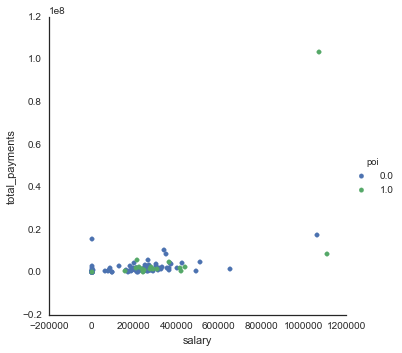

In [33]:
sns.FacetGrid(df, hue="poi", size=5) \
   .map(plt.scatter, "salary", "total_payments") \
   .add_legend()

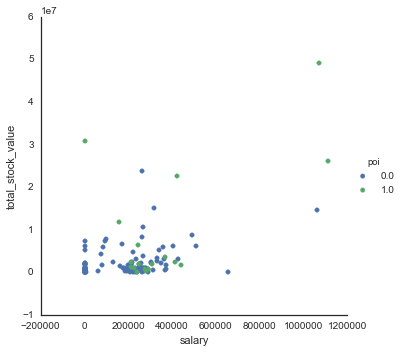

In [36]:
sns.FacetGrid(df, hue="poi", size=5) \
   .map(plt.scatter, "salary", "total_stock_value") \
   .add_legend()

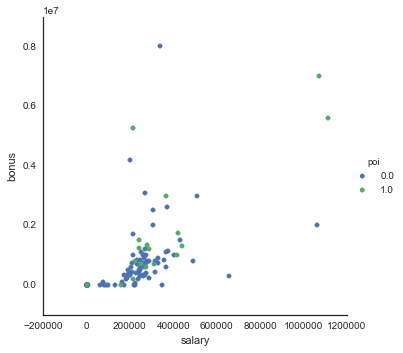

In [42]:
sns.FacetGrid(df, hue="poi", size=5) \
   .map(plt.scatter, "salary", "bonus") \
   .add_legend()

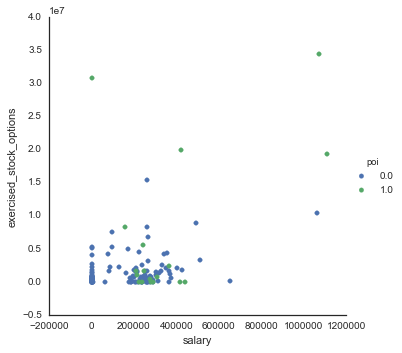

In [43]:
sns.FacetGrid(df, hue="poi", size=5) \
   .map(plt.scatter, "salary", "exercised_stock_options") \
   .add_legend()

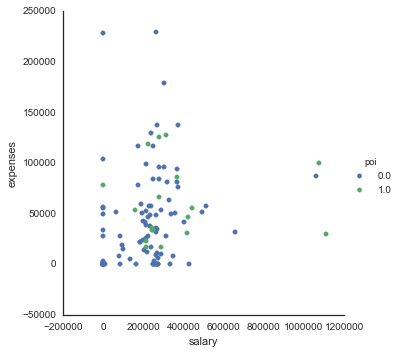

In [44]:
sns.FacetGrid(df, hue="poi", size=5) \
   .map(plt.scatter, "salary", "expenses") \
   .add_legend()

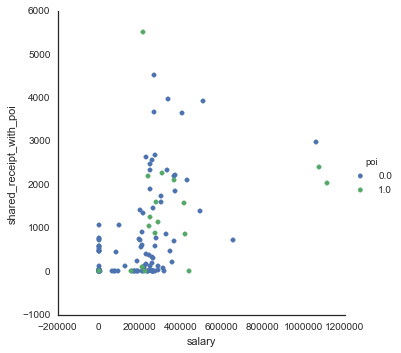

In [47]:
sns.FacetGrid(df, hue="poi", size=5) \
   .map(plt.scatter, "salary", "shared_receipt_with_poi") \
   .add_legend()

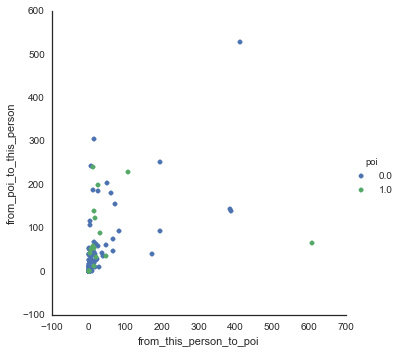

In [45]:
sns.FacetGrid(df, hue="poi", size=5) \
   .map(plt.scatter, "from_this_person_to_poi", "from_poi_to_this_person") \
   .add_legend()

From above plots, there don't seem to be outliers with invalid values. So no further data processing is performed.

## 3. Feature Selection & Engineering

### 3.1 Feature Selection  
Manual feature selection approach is adopted. The high levle process is as following:
* Decision Tree classifier is used for feature selection  
* Start with small number of features  
* Add feature gradually from financial and email; discard it if performance metrics (precision and recall) dropped significantly  

Following are the exact steps of feature selection with evaluation metrics documented.

1.features_list = ['poi','salary']  
Accuracy: 0.70170	Precision: 0.25114	Recall: 0.24800  

2.features_list = ['poi','salary', 'from_this_person_to_poi']  
Accuracy: 0.74564	Precision: 0.26990	Recall: 0.23400  

3.features_list = ['poi','salary', 'bonus', 'from_this_person_to_poi']  
Accuracy: 0.69691	Precision: 0.15689	Recall: 0.15250  

4.features_list = ['poi', 'salary', 'from_poi_to_this_person', 'from_this_person_to_poi']  
Accuracy: 0.73118	Precision: 0.22735	Recall: 0.19950  

5.features_list = ['poi', 'salary', 'from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi']  
Accuracy: 0.76892	Precision: 0.25919	Recall: 0.20800  

6.features_list = ['poi', 'salary', 'total_payments', 'from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi']  
Accuracy: 0.76421	Precision: 0.18407	Recall: 0.18950  

7.features_list = ['poi', 'salary', 'exercised_stock_options', 'from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi']  
Accuracy: 0.81077	Precision: 0.37122	Recall: 0.33150  

8.features_list = ['poi', 'salary', 'exercised_stock_options', 'expenses', 'from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi']  
Accuracy: 0.83593	Precision: 0.42012	Recall: 0.39050  

9.features_list = ['poi', 'salary', 'exercised_stock_options', 'total_stock_value', 'expenses', 'from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi']  
Accuracy: 0.82729	Precision: 0.39115	Recall: 0.37550  

Best features list derived from original dataset is No.8 listed above. This features list is selected in following section.  

### 3.2 Add New Feature
New feature 'poi_ratio', ratio between number of mails involving POIis added and total number of mails, was added. However this new feature doesn't improve metrics (in fact slightly degraded):  
Accuracy: 0.81964	Precision: 0.36518	Recall: 0.35550   

### 3.3 Feature Scaling
All features are scaled using sklearn.preprocessing.scale(features). This is because features with different scales have impact on some algorithms (i.e GaussianNB). By applying feature re-scaling, we can compare features at different scales(originally) so as to avoid dominant features.

## 4. Picking and Tuning Algorithms

Decision Tree, GaussianNB, Logistic Regression were tried out. Based on the performace metrices (see below section), Decision Tree Classifer gives the best result. Hence Decision Tree Classifier was selected for final tuning.  

DecisionTreeClassifier was tuned using GridSearchCV with parameters - {'criterion':('gini', 'entropy'),'splitter':('best','random')}. 

## 5. Validating and Evaluation

### 5.1 Validation and its importances  
Validation is the process of randomly splitting the data into training and testing data. Then the model can be trained on the training data, and be validated on the testing data. The training and testing random data split is 70% and 30% respectively for the project. The importances of applying training/testing data split are:  
* provides estimate of algorithm performance on an indepedent dataset
* serves as check on overfitting

### 5.2 Evaluation Metrics  
Given that the allocation of POI/non-POI is skewed (very unbalanced). The evaluation for this project is mainly based on Precision and Recall metrics:  

* Precision = True Positive/(True Positive + False Positive). It's the proportion of correct prediction of all the people who are predicted to be POI.  
* Recall = True Positive/(True Positive + False Positive). It's the proportion of correct prediciton of all the people who are actually POI.

Performance metrices of all three classifiers tried out are as below:   
* Decision Tree - Accuracy: 0.81786	Precision: 0.35751	Recall: 0.34500  
* GaussianNB - Accuracy: 0.83779	Precision: 0.38585	Recall: 0.22900  
* Logistic Regression - Accuracy: 0.65050	Precision: 0.05119	Recall: 0.08250

## 6. References  
1. SKLearn documentation: http://scikit-learn.org/stable/documentation.html